<a href="https://colab.research.google.com/github/sanislearning/ml_playground/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [40]:
drive.mount("/content/drive")
file_path='/content/drive/MyDrive/PData/mnist/train-images.idx3-ubyte'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import struct #helps interpret bytes as packed binary data, lets us read IDX file format
with open(file_path,'rb') as f: #rb means read binary
  #Read the magic number and dimensions
  magic,num_images,rows,cols=struct.unpack('>IIII',f.read(16))
  #f.read(16) means that you read first 16 bytes, ie header of IDX file, ie metadata of file
  #struct.unpack('>IIII',...) interprets those 16 bytes as 4 big-endian unsigned integers
  # > =  Big endian (most significant byte first)

  print("Magic Number: ",magic)
  print("Number of Images: ",num_images)
  print("Image Size: ",rows,"x",cols)
  image_bytes=f.read(rows*cols)  #reads only the first image
  image=np.frombuffer(image_bytes,dtype=np.uint8).reshape((rows,cols))
  #converts the bytes into a NumPy array and then reshapes it into a 2D array of shape

Magic Number:  2051
Number of Images:  60000
Image Size:  28 x 28


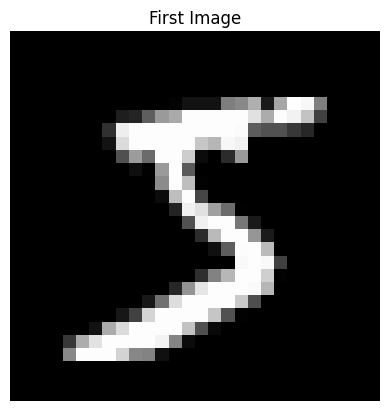

In [42]:
#Visualizing the Image
plt.imshow(image,cmap='gray')
plt.title("First Image")
plt.axis('off')
plt.show()

In [43]:
with open(file_path,'rb') as f: #read binary format
  f.read(16) #skips the header
  image_data=f.read(num_images*rows*cols)

images=np.frombuffer(image_data,dtype=np.uint8) #converts the raw bytes into a NumPy array, interpret each byte as an unsigned 8-bit integer
images=images.reshape((num_images,rows,cols)) #It's a 3D array. It has 60000 images, each 28th rows high and 28 columns wide

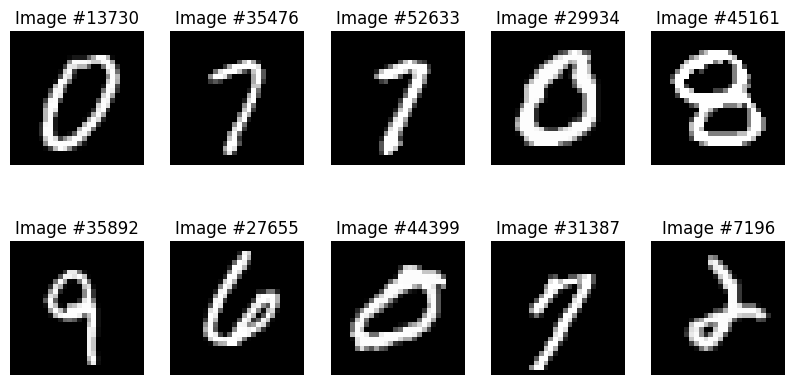

In [44]:
import random

plt.figure(figsize=(10, 5))
for i in range(10):
    idx = random.randint(0, 59999)
    plt.subplot(2, 5, i+1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Image #{idx}")
    plt.axis('off')
plt.show()

In [45]:
images=images/255.0

#Load the Labels

In [46]:
label_file_path='/content/drive/MyDrive/PData/mnist/train-labels.idx1-ubyte'

with open(label_file_path,'rb') as f:
  magic,num_labels=struct.unpack('>II',f.read(8))
  print("Magic Number: ",magic)
  print("Number of Labels: ",num_labels)

  #Read the rest of the file - each label is 1 byte
  label_bytes=f.read(num_labels)
  #Convert to a NumPy array of unsigned 8-bit intergers
  labels=np.frombuffer(label_bytes,dtype=np.uint8)

Magic Number:  2049
Number of Labels:  60000


In [47]:
x=images.reshape((num_images,28*28)) # each image becomes a 784-length vector

In [48]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x,labels,test_size=0.2,random_state=42)
#x_train,y_train is used for training
#x_val,y_val is used for validation/testing

#Training and Evaluation

##LogisticRegression

In [49]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV

In [50]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(x_train,y_train)
y_pred=model.predict(x_val)

In [51]:
print(accuracy_score(y_val,y_pred)*100)

92.23333333333333


In [52]:
model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2', max_iter=1000, n_jobs=-1)
model.fit(x_train, y_train)
y_pred=model.predict(x_val)

In [53]:
lr_accuracy=accuracy_score(y_val,y_pred)*100
print(accuracy_score(y_val,y_pred)*100)

92.20833333333334


##RandomForest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(x_train,y_train)
y_pred=rf.predict(x_val)
rf_accuracy=accuracy_score(y_val,y_pred)*100
print(f"Random Forest Accuracy: {accuracy_score(y_val,y_pred)*100:.2f}")

Random Forest Accuracy: 96.67


##Support Vector Machine (SVM)

In [58]:
from sklearn.svm import SVC

model=SVC()
model.fit(x_train,y_train)
y_pred=model.predict(x_val)

In [59]:
svm_accuracy=accuracy_score(y_val,y_pred)*100
print(f"SVM Accuracy: {accuracy_score(y_val,y_pred)*100:.2f}")

SVM Accuracy: 97.76


##Neural Network

In [73]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint

In [74]:
model=models.Sequential([
    layers.Dense(128,activation='relu',input_shape=(784,)),
    layers.Dense(64,activation='relu'),
    layers.Dense(10,activation='softmax')
])
#Dense means fully connected layer
#softmax means that the predicted values all sum up to 1 and the highest prediction is the right one

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#adam means adaptive optimizer
#spare_categorical_crossentropy is used when you have multiple classes
checkpoint=ModelCheckpoint("best_model.keras",monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)
model.fit(x_train,y_train,epochs=5,batch_size=32,validation_data=(x_val,y_val),callbacks=[checkpoint])

Epoch 1/5
1489/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.0165
Epoch 1: val_accuracy improved from -inf to 0.97775, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9946 - loss: 0.0165 - val_accuracy: 0.9778 - val_loss: 0.1025
Epoch 2/5
1494/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - loss: 0.0114
Epoch 2: val_accuracy did not improve from 0.97775
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9961 - loss: 0.0114 - val_accuracy: 0.9758 - val_loss: 0.1070
Epoch 3/5
1491/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0125
Epoch 3: val_accuracy did not improve from 0.97775
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 0.9768 - val_loss: 0.1131
Epoch 4/5
1487/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.0093
Epoch 4: val_accuracy improved from 0.97775 to 0.97783, saving model to best_model.keras
1500/1500 ━━━━━━━

In [82]:
model = tf.keras.models.load_model("best_model.keras")
nn_loss, nn_acc = model.evaluate(x_val, y_val)
print(f"Neural Network Accuracy: {nn_acc * 100:.2f}%")
nn_acc = nn_acc * 100

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9789 - loss: 0.1104
Neural Network Accuracy: 97.87%


##Comparison

<ipython-input-83-4e3f42ab7e8c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model',y='Accuracy',data=accuracy_data,palette='viridis')


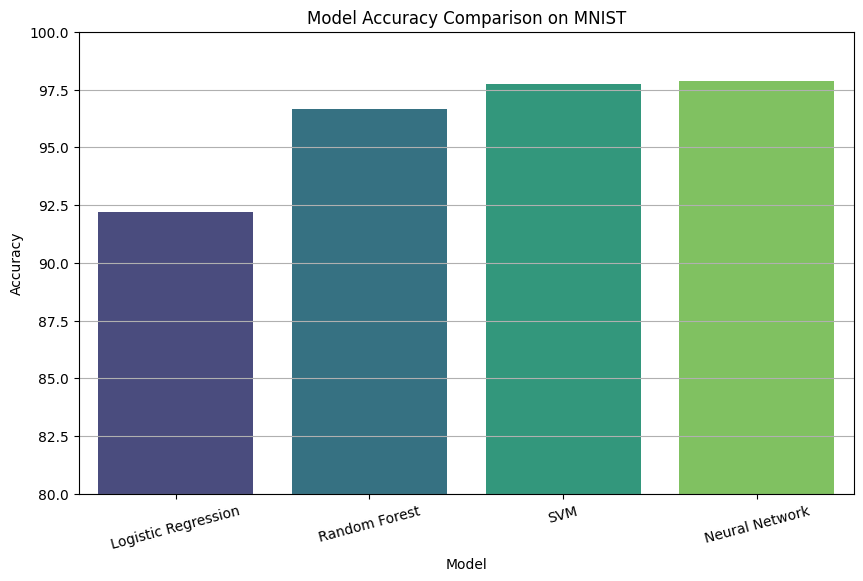

In [83]:
accuracy_data=pd.DataFrame({
    'Model':["Logistic Regression",'Random Forest','SVM','Neural Network'],
    'Accuracy':[lr_accuracy,rf_accuracy,svm_accuracy,nn_acc]
})
plt.figure(figsize=(10,6))
sns.barplot(x='Model',y='Accuracy',data=accuracy_data,palette='viridis')
plt.ylim(80,100)
plt.title('Model Accuracy Comparison on MNIST')
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()